# Modelo

Modelo: LightGBM

Dataset: eliminamos variables con datadrifting (cprestamos_personales y mprestamos_personales), el resto del feature engineering consiste en sumar algunas variables que tenia sentido agrupar, promedios moviles considerando los ultimos 3 meses (incluido el mes corriente), pendiente (slope) sobre la misma ventana de tiempo que los promedios moviles.

Estrategia de entrenamiento: solo abril

In [3]:
# %pip install scikit-learn==1.3.2
# %pip install seaborn==0.13.1
# %pip install numpy==1.26.4
# %pip install matplotlib==3.7.1
# %pip install pandas==2.1.4
# %pip install lightgbm==4.4.0
# %pip install optuna==3.6.1

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

import lightgbm as lgb

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_contour

from time import time

import pickle

In [2]:
base_path = 'C:/Eugenio/Maestria/DMEyF/'

dataset_path = base_path + 'datasets/'
modelos_path = base_path + 'modelos/'
db_path = base_path + 'db/'
dataset_file = 'competencia_01_fe_v02.csv'

ganancia_acierto = 273000
costo_estimulo = 7000

# agregue sus semillas
semillas = [122219, 109279, 400391, 401537, 999961]

data = pd.read_csv(dataset_path + dataset_file)

In [3]:
meses_train = [202104]

In [4]:
# Asignamos pesos a las clases

data['clase_peso'] = 1.0

data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

In [5]:
data['clase_binaria1'] = 0
data['clase_binaria2'] = 0
data['clase_binaria1'] = np.where(data['clase_ternaria'] == 'BAJA+2', 1, 0)
data['clase_binaria2'] = np.where(data['clase_ternaria'] == 'CONTINUA', 0, 1)

Para evaluar la calidad del modelo, crearemos nuestra propia función de evaluación que calcule la ganancia. La razón de incluir los pesos es precisamente para poder implementar esta función de evaluación de manera adecuada. Al combinar las clases *BAJA+1* y *BAJA+2* en una sola, necesitamos una forma de diferenciarlas, y es aquí donde entra en juego el *weight*. Este parámetro nos permitirá distinguir entre ambas clases al momento de evaluarlas dentro del algoritmo.


In [6]:
def lgb_gan_eval(y_pred, data):
    weight = data.get_weight()
    ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - np.where(weight < 1.00002, costo_estimulo, 0)
    ganancia = ganancia[np.argsort(y_pred)[::-1]]
    ganancia = np.cumsum(ganancia)

    return 'gan_eval', np.max(ganancia) , True

# Parámetros del modelo.
params = {
    'objective': 'binary',
    'metric': 'gan_eval',
    'boosting_type': 'gbdt',
    'max_bin': 31,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.3,
    'bagging_fraction': 0.7,
    'verbose': 0
}

In [7]:
train_data = data[data['foto_mes'].isin(meses_train)]

X_train = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1 = train_data['clase_binaria1'] # Solo BAJA+2
y_train_binaria2 = train_data['clase_binaria2'] # junta a los 2 BAJA
w_train = train_data['clase_peso']

In [7]:
# No imputo nulos porque el modelo los maneja

# imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
# Xif = imp_mean.fit_transform(X_test)

# Optimizacion

A continuación, procederemos a optimizar **LightGBM** utilizando la librería **Optuna**.


In [8]:
def objective(trial):

    num_leaves = trial.suggest_int('num_leaves', 8, 100), 
    learning_rate = trial.suggest_float('learning_rate', 0.005, 0.05), # mas bajo, más iteraciones necesita
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 1000),
    feature_fraction = trial.suggest_float('feature_fraction', 0.1, 1.0),
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.1, 1.0),

    params = {
        'objective': 'binary',
        'metric': 'custom',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'min_data_in_leaf': min_data_in_leaf,
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'seed': semillas[0],
        'verbose': -1
    }
    
    train_data = lgb.Dataset(X_train,
                              label=y_train_binaria2, # considera a los 2 BAJA en la misma categoria
                              weight=w_train)
    
    # print(f"Learning Rate: {learning_rate}, Type: {type(learning_rate)}")
    
    # Use callbacks for early stopping
    early_stopping_cb = lgb.early_stopping(stopping_rounds=50)
        
    cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=1000,
        callbacks=[early_stopping_cb],
        feval=lgb_gan_eval,
        stratified=True,
        nfold=5,
        seed=semillas[0]
    )
    
    max_gan = max(cv_results['valid gan_eval-mean'])
    best_iter = cv_results['valid gan_eval-mean'].index(max_gan) + 1

    # Guardamos cual es la mejor iteración del modelo
    trial.set_user_attr("best_iter", best_iter)

    return max_gan * 5

In [9]:
storage_name = "sqlite:///" + db_path + "optimization_lgbm.db" # una copia del archivo se encuentra en la carpeta "final model" con el resto de los archivos que generan la prediccion final
study_name = "exp_301_lgbm_v03"

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

[I 2024-10-13 15:54:49,829] Using an existing study with name 'exp_301_lgbm_v03' instead of creating a new one.


In [14]:
# study.optimize(objective, n_trials=100)

In [10]:
optuna.visualization.plot_optimization_history(study)

In [11]:
plot_param_importances(study)

El **learning rate** es un parámetro que tiene que ir acompañado por más árboles.

In [12]:
plot_slice(study)

In [13]:
plot_contour(study)

In [14]:
plot_contour(study, params=['num_leaves','min_data_in_leaf'] )

Y finalmente tomamos el mejor modelo y lo entrenamos con la totalidad de los datos

In [15]:
best_iter = study.best_trial.user_attrs["best_iter"]
print(f"Mejor cantidad de árboles para el mejor model {best_iter}")
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': study.best_trial.params['num_leaves'],
    'learning_rate': study.best_trial.params['learning_rate'],
    'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],
    'feature_fraction': study.best_trial.params['feature_fraction'],
    'bagging_fraction': study.best_trial.params['bagging_fraction'],
    'seed': semillas[0],
    'verbose': 0
}

train_data = lgb.Dataset(X_train,
                          label=y_train_binaria2,
                          weight=w_train)

model = lgb.train(params,
                  train_data,
                  num_boost_round=best_iter)


Mejor cantidad de árboles para el mejor model 381


Variables más importantes para el modelo:

In [16]:
importances = model.feature_importance()
feature_names = X_train.columns.tolist()
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values('importance', ascending=False)
importance_df[importance_df['importance'] > 0]


feature  importance
189            avg3_mrentabilidad_annual         200
5                           cliente_edad         198
365                 slope_mcuentas_saldo         195
22                        mcuentas_saldo         186
125                     Master_fechaalta         185
..                                   ...         ...
209                 avg3_ctarjeta_master           1
307             avg3_Visa_madelantopesos           1
57   ctarjeta_master_debitos_automaticos           1
263            avg3_ccheques_depositados           1
122                       Master_mpagado           1

[511 rows x 2 columns]

Para guardar el modelo para poder utilizarlo más adelante, no es necesario guardarlo como *pickle*, la librería nos permite guardarlo en formato texto

In [24]:
# model.save_model(modelos_path + 'lgb_v003.txt') # una copia del archivo se encuentra en la carpeta "final model" con el resto de los archivos que generan la prediccion final

# Backtesting

Entreno con marzo y estimo para abril porque eran los unicos 2 meses para los cuales tengo todas las varibales temporales

In [17]:
train_data = data[data['foto_mes'] == 202103]
test_data = data[data['foto_mes'] == 202104]

X_train = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1 = train_data['clase_binaria1']
y_train_binaria2 = train_data['clase_binaria2']
w_train = train_data['clase_peso']

X_test = test_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_test_binaria1 = test_data['clase_binaria1']
y_test_class = test_data['clase_ternaria']
w_test = test_data['clase_peso']

In [18]:
best_iter = study.best_trial.user_attrs["best_iter"]
print(f"Mejor cantidad de árboles para el mejor model {best_iter}")
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': study.best_trial.params['num_leaves'],
    'learning_rate': study.best_trial.params['learning_rate'],
    'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],
    'feature_fraction': study.best_trial.params['feature_fraction'],
    'bagging_fraction': study.best_trial.params['bagging_fraction'],
    'seed': semillas[0],
    'verbose': 0
}

Mejor cantidad de árboles para el mejor model 381


In [19]:
train_data = lgb.Dataset(X_train,
                          label=y_train_binaria2,
                          weight=w_train)

In [20]:
model = lgb.train(params,
                  train_data,
                  num_boost_round=best_iter)


obtenemos la predicción de **Abril**

In [21]:
y_pred_lgm = model.predict(X_test)

In [22]:
ganancia = np.where(y_test_binaria1 == 1, ganancia_acierto, 0) - np.where(y_test_binaria1 == 0, costo_estimulo, 0)

idx = np.argsort(y_pred_lgm)[::-1]

ganancia = ganancia[idx]
y_pred_lgm = y_pred_lgm[idx]

ganancia_cum = np.cumsum(ganancia)


Cantidad optima de envios:

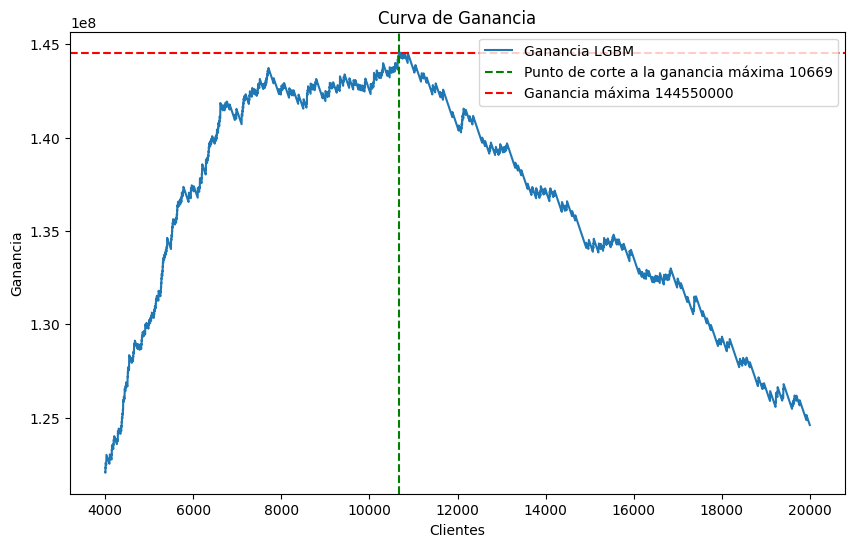

In [23]:
piso_envios = 4000
techo_envios = 20000

ganancia_max = ganancia_cum.max()
gan_max_idx = np.where(ganancia_cum == ganancia_max)[0][0]

plt.figure(figsize=(10, 6))
plt.plot(range(piso_envios, len(ganancia_cum[piso_envios:techo_envios]) + piso_envios), ganancia_cum[piso_envios:techo_envios], label='Ganancia LGBM')
plt.axvline(x=gan_max_idx, color='g', linestyle='--', label=f'Punto de corte a la ganancia máxima {gan_max_idx}')
plt.axhline(y=ganancia_max, color='r', linestyle='--', label=f'Ganancia máxima {ganancia_max}')
plt.title('Curva de Ganancia')
plt.xlabel('Clientes')
plt.ylabel('Ganancia')
plt.legend()
plt.show()


# Generar prediccion para Kaggle

In [24]:
# Mejores parametros que habian surgido de la optimizacion de Optuna

best_iter = 381 # cantidad de arboles del mejor modelo

params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': 57,
    'learning_rate': 0.02430667011066182,
    'min_data_in_leaf': 741,
    'feature_fraction': 0.43258351876617523,
    'bagging_fraction': 0.4885097776912656,
    'seed': 122219,
    'verbose': 0
}

# y cantidad optima de envios segun backtesting
corte = 10669

In [25]:
train_data = data[data['foto_mes'].isin([202104])]
future_data = data[data['foto_mes'] == 202106]

X_train = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1 = train_data['clase_binaria1']
y_train_binaria2 = train_data['clase_binaria2']
w_train = train_data['clase_peso']

X_test = future_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)

Entreno el modelo con los datos de abril y los parametros optimos de Optuna

In [26]:
train_data = lgb.Dataset(X_train,
                          label=y_train_binaria2,
                          weight=w_train)

In [27]:
model = lgb.train(params,
                  train_data,
                  num_boost_round=best_iter)


Hago la prediccion para junio

In [28]:
y_pred_lgm = model.predict(X_test)

In [29]:
# Agrego la prediccion en el dataset de test
X_test['pred_lgm'] = y_pred_lgm

#  ordeno por probabilidad para marcar a quienes les vamos a enviar el estimulo
idx = np.argsort(y_pred_lgm)[::-1]
X_test.reset_index(drop=True, inplace=True) # reseteo el index para poder ordenar por idx, sino en index tenia por default el numero de fila del dataframe original "data"
X_test = X_test.iloc[idx]

# genero la columna con 1s para los que van a recibir el estimulo, 0 para todo el resto
envios = np.zeros(len(X_test), dtype=int)
envios[:corte] = 1
X_test['Predicted'] = envios

# otra forma seria:
# X_test['Predicted'] = 0
# X_test.loc[:gan_max_idx-1, 'Predicted'] = 1

Genero el archivo para kaggle

In [30]:
output = X_test[['numero_de_cliente', 'Predicted']]

file_name = 'results_v03_final.csv'
output_path = base_path + 'exp/KA2001/' + file_name

output.to_csv(output_path, index=False)